In [1]:
import psi4
import matplotlib.pyplot as plt
import numpy as np

psi4.set_options({"save_jk" : True})
psi4.set_memory(int(2.50e9))
psi4.core.clean()

import n2v

---
### Perform target calculation with Psi4. 
#### Store wavefunction (wfn) object

In [22]:
Be = psi4.geometry( 
""" 
0 1
Be
noreorient
nocom
units bohr
symmetry c1
""" )

psi4.set_options({"reference" : "rhf"})
e, wfn = psi4.energy("ccsd/aug-cc-pvtz", return_wfn=True, molecule=Be)



---
#### Feed wfn object to Inverter class. 
##### Invert!

In [23]:
ibe = n2v.Inverter(wfn)
ibe.invert(potential_components=["fermi_amaldi"])

Optimization Successful


---
To visualize the generated potential. A rectangular grid must be built. 

In [24]:
ibe.build_rectangular_grid(L = [0.1, 0.1, 5], 
                                D = [0.1, 0.1, 0.1], one_dim=True, return_hartree=True)

/mnt/c/Users/victo/Dropbox/PHD/n2v/n2v/grider.py:105: UserWarning: Only LDA fucntionals are supported on the grid
  warnings.warn("Only LDA fucntionals are supported on the grid")


Extract the desired quantities from the grid attribute. 

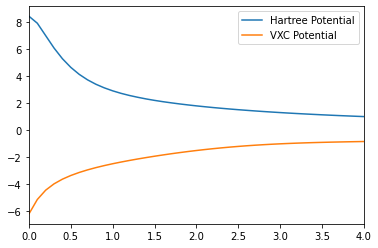

In [30]:
v_inv = (ibe.grid.z_vopt + ibe.grid.z_vfa)

plt.plot(ibe.grid.z, ibe.grid.z_hartree,          label="Hartree Potential")
plt.plot(ibe.grid.z, -v_inv,                       label="VXC Potential")

plt.xlim((0,4))

plt.legend()